In [7]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import seaborn as sns

#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors

import uproot
import gc

from cells import Cells 

MCdata="cell_analysis_mu60"
MC_root = f"../re21.9/{MCdata}/cells.root"
tree_name = "ntuple"
        
x_bin = np.linspace(-3.15, 3.15, num=33)
y_bin = np.linspace(-5, 5, num=51)

cell_data = Cells(MC_root, unit="GeV")
cell_imgs, cell_label = cell_data.cimg(x_bin, y_bin, batch_size=500)

print(f"Cell image shape: {cell_imgs.shape}")
print(f"Image label shape: {cell_label.shape}")

gc.collect()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cell image shape: (47000, 50, 32, 2)
Image label shape: (47000, 2)


0

# prepare data

In [111]:
from sklearn.model_selection import train_test_split
import os
def plot_loss(history):
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        #plt.ylim([0.01, 15000])
        plt.yscale('log')
        if 'val_accuracy' in history.history.keys():
            plt.plot(history.history['val_accuracy'], label='val_acc')
        plt.xlabel('Epoch')
        plt.ylabel('Error ')
        plt.legend()
        plt.grid(True)
        
def train_dnn_model(model, X, y, epochs=20, model_path="model_weights"):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.1, random_state=42,
                                                        shuffle=True
                                                       )
    x_train, x_test = x_train.reshape((-1,50*32*2)), x_test.reshape((-1,50*32*2))

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    
    os.makedirs(model_path, exist_ok = True)
    checkpoint_filepath = f"./{model_path}/best_model"
    save_best_callback = tf.keras.callbacks.ModelCheckpoint(
                                                            filepath=checkpoint_filepath,
                                                            save_weights_only=True,
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True)
    
    history = model.fit(x_train, y_train, 
                        batch_size= 1024,
                        epochs=epochs, 
                        verbose=0, validation_split=0.15,
                        callbacks=[save_best_callback]
                       )
    #model.load_weights(checkpoint_filepath)
    
    #plot train and val loss
    plot_loss(history)

    #Test model
    test_model(model, x_test, y_test,model_path)
    
    
def test_model(model, x_test, y_test, output_path):
    predicted = model.predict(x_test)

    def np_met(X, axis=1):
        return np.sqrt( np.sum(np.square(X), axis) )

    predicted_met = np_met(predicted)
    true_met = np_met(y_test)
    
    fig = plt.figure(figsize =(8, 6))
    #plt.scatter(np.squeeze(true_met),np.squeeze(predicted_met), marker='o', alpha=0.7)
    plt.hist2d(np.squeeze(true_met),np.squeeze(predicted_met),bins=100, 
               cmap='jet', cmin=0.5)
    plt.colorbar()
    plt.xlabel("truth met")
    plt.ylabel("predicted met")
    plt.savefig(f"{output_path}/pred_met_scatter.pdf")
    
    fig = plt.figure(figsize =(8, 6))
    _,bins,_ = plt.hist(true_met, bins=100, alpha=0.5, histtype='step', color='Blue')
    _ = plt.hist(predicted_met, bins=bins,alpha=0.7, color='red')
    plt.xlabel(f"MET")
    plt.ylabel("counts")
    plt.savefig(f"{output_path}/pred_met.pdf")
    
    #plot predictict
    def plot_XY(y_pred, y_true, label):
        fig = plt.figure(figsize =(8, 6))
        #plt.scatter(np.squeeze(y_true),np.squeeze(y_pred), marker='o', alpha=0.7)
        plt.hist2d(np.squeeze(y_true),np.squeeze(y_pred),bins=100, cmap='jet', cmin=1)
        plt.colorbar()
        plt.xlabel(f"truth {label}")
        plt.ylabel(f"predicted {label}")
        ##Hist plot
        fig = plt.figure(figsize =(8, 6))
        _,bins,_ = plt.hist(y_true, bins=100, alpha=0.5, histtype='step', color='Blue')
        _ = plt.hist(y_pred, bins=bins,alpha=0.7, color='red')
        plt.xlabel(f"MET {label}")
        plt.ylabel("counts")
        plt.savefig(f"{output_path}/pred_{label}.pdf")
        
    plot_XY(predicted[:,1], y_test[:,1], label='Y')
    plot_XY(predicted[:,0], y_test[:,0], label='X')
    
    #Diff between pred and truth
    delta = true_met-predicted_met
    #gc.collect()
    fig = plt.figure(figsize =(8, 6))
    _ = plt.hist(delta, bins=100)
    plt.xlabel("truth - pred")
    plt.ylabel("counts")
    plt.savefig(f"{output_path}/pred_met_diff.pdf")
gc.collect()


0

# ML Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


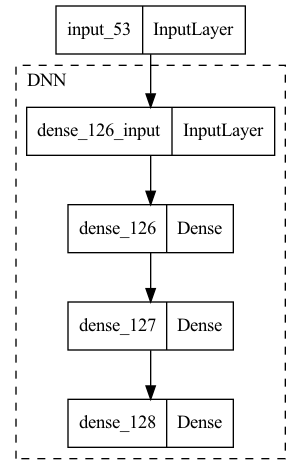

In [123]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow.keras.layers import Input, InputLayer, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, GaussianNoise
from tensorflow.keras import backend as K

import models

def tf_sqrt(X, axis=-1):
    Y = tf.math.square(X)
    Y = tf.math.reduce_sum(Y, axis=axis, keepdims=True)
    return tf.math.sqrt(Y)

class MeanSquaredError(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        met_true = tf_sqrt(y_true, 1)
        met_pred = tf_sqrt(y_pred, 1)
        met_loss = tf.keras.losses.MeanSquaredError()(met_true, met_pred)
        mse_loss_x = tf.keras.losses.MeanSquaredError()(y_true[:,0], y_pred[:,0])
        mse_loss_y = tf.keras.losses.MeanSquaredError()(y_true[:,1], y_pred[:,1])
        return mse_loss_x+mse_loss_y+met_loss



x=tf.keras.Input(shape=(50*32*2,) )

model_DNN = Model(
                inputs=x,
                outputs = models.DNN(h_dim=[10,10], out_dim=2,
                                     activation='relu', 
                                     L1L2=tf.keras.regularizers.L1L2(l1=0.0, l2=0.1))(x)
             )


model_DNN.compile(optimizer=Adam(learning_rate=1e-3),
              loss=MeanSquaredError(), 
              metrics=['mean_absolute_error', 'accuracy'] 
             )

gc.collect()

tf.keras.utils.plot_model(model_DNN, expand_nested=True)



x_train shape: (42300, 3200)
y_train shape: (42300, 2)
147/147 [==============================] - 0s 516us/step


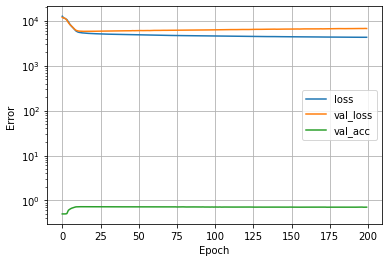

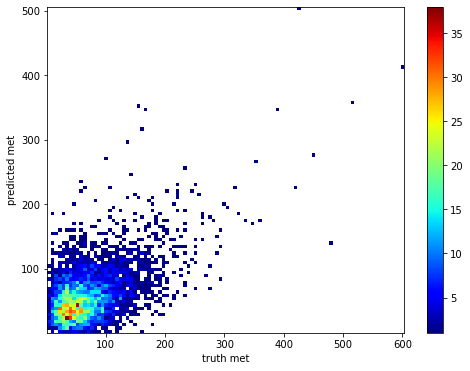

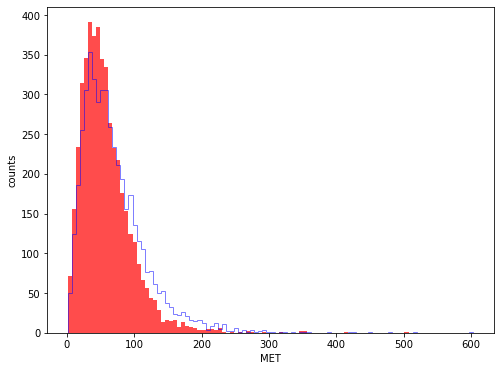

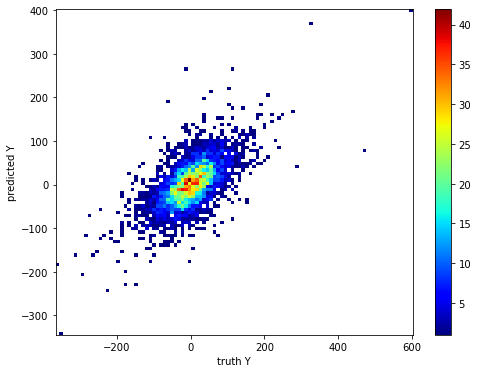

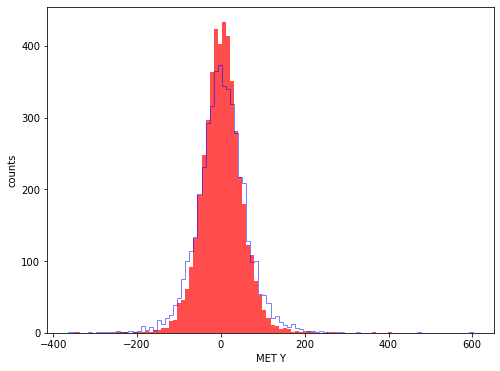

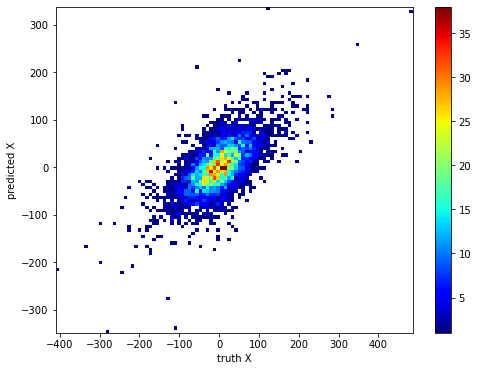

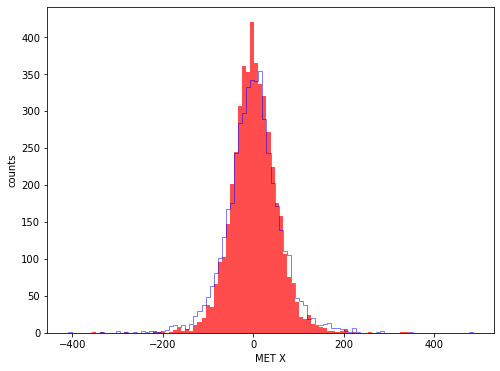

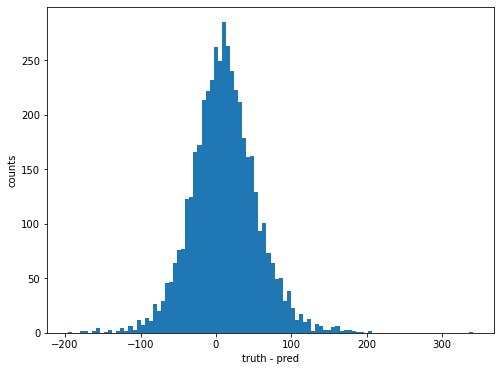

In [124]:
train_dnn_model(model_DNN, cell_imgs, cell_label, epochs=200, model_path='outputs/NN10_10_l2')


In [119]:
gc.collect()

65503